# Knowledge Graph Construction Pipeline

This notebook demonstrates the complete process of building a knowledge graph from raw text data. The pipeline includes:

1. Text collection through web scraping
2. Text preprocessing and cleaning
3. Named Entity Recognition (NER)
4. Relation Extraction (RE)
5. Knowledge Graph Construction
6. Visualization and querying

## Setup

First, let's import the necessary libraries and set up the environment.

In [1]:
# Import standard libraries
import os
import sys
import json
import logging
from pprint import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

In [2]:
# Add project root to path for importing local modules
# Adjust this path if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import project modules
from src.data_collection.scraper import NewsArticleScraper
from src.preprocessing.cleaner import clean_text
from src.entity_recognition.ner import SpacyNERExtractor, CRFExtractor
from src.entity_recognition.comparison import NERComparison
from src.relation_extraction.extractor import SpacyRelationExtractor
from src.knowledge_graph.builder import KnowledgeGraphBuilder

# Create output directories
os.makedirs('output/data', exist_ok=True)
os.makedirs('output/models', exist_ok=True)
os.makedirs('output/visualization', exist_ok=True)

2025-03-07 20:57:17,854 - datasets - INFO - PyTorch version 2.6.0 available.
2025-03-07 20:57:17,854 - datasets - INFO - TensorFlow version 2.18.0 available.


## 1. Data Collection

Let's collect news articles from Reuters using our web scraper.

In [14]:
# Initialize scraper
scraper = NewsArticleScraper(output_dir='output/data/raw')

# Scrape articles
# Note: This might take a while and might be rate-limited by the website
# For demonstration, we get just 3 articles
try:
    article_files = scraper.scrape_reuters(num_articles=15, category='business')
    print(f"Scraped {len(article_files)} articles:")
    for file in article_files:
        print(f"- {os.path.basename(file)}")
except Exception as e:
    logger.error(f"Error scraping articles: {e}")
    # Use example data if scraping fails
    logger.info("Using example data instead")
    # Create a simple example article
    example_article = {
        "id": "example1",
        "title": "Apple announces new partnership with Microsoft",
        "url": "https://example.com/article1",
        "source": "example",
        "category": "business",
        "published_date": "2023-01-01",
        "scraped_date": "2023-01-02",
        "content": "Apple Inc. has announced a new partnership with Microsoft Corporation, according to CEO Tim Cook. \
The collaboration will focus on cloud computing services and AI integration. \
The partnership was revealed at a press conference in Cupertino, California yesterday. \
Microsoft CEO Satya Nadella expressed excitement about working with the iPhone maker. \
Apple was founded by Steve Jobs in 1976 and has become one of the world's most valuable companies."
    }
    
    # Save example article
    os.makedirs('output/data/raw', exist_ok=True)
    example_file = 'output/data/raw/example_article.json'
    with open(example_file, 'w', encoding='utf-8') as f:
        json.dump(example_article, f, ensure_ascii=False, indent=4)
    
    article_files = [example_file]

2025-03-07 21:03:35,580 - src.data_collection.scraper - INFO - Output directory set to: output/data/raw
2025-03-07 21:03:35,580 - src.data_collection.scraper - INFO - Scraping 15 articles from Reuters/business
2025-03-07 21:03:35,580 - WDM - INFO - ====== WebDriver manager ======
2025-03-07 21:03:36,317 - WDM - INFO - Get LATEST chromedriver version for google-chrome
2025-03-07 21:03:36,421 - WDM - INFO - Get LATEST chromedriver version for google-chrome
2025-03-07 21:03:36,527 - WDM - INFO - Driver [C:\Users\hbonn\.wdm\drivers\chromedriver\win64\133.0.6943.141\chromedriver-win32/chromedriver.exe] found in cache
2025-03-07 21:03:37,563 - src.data_collection.scraper - INFO - Navigating to https://www.reuters.com/business/
2025-03-07 21:03:41,235 - src.data_collection.scraper - INFO - FOUND ARTICLES ELEMENTS : 20
2025-03-07 21:03:43,241 - src.data_collection.scraper - INFO - Dealing with article : 1
2025-03-07 21:03:48,252 - src.data_collection.scraper - WARNING - Invalid article link: N

Scraped 14 articles:
- reuters_20250307_210517_.json
- reuters_20250307_210553_.json
- reuters_20250307_210638_.json
- reuters_20250307_210718_.json
- reuters_20250307_210755_.json
- reuters_20250307_210831_.json
- reuters_20250307_210912_.json
- reuters_20250307_211000_.json
- reuters_20250307_211035_.json
- reuters_20250307_211115_.json
- reuters_20250307_211202_.json
- reuters_20250307_211251_.json
- reuters_20250307_211325_.json
- reuters_20250307_211408_.json


## 2. Text Preprocessing

Now let's preprocess the text from the articles we collected.

In [15]:
# Load articles
articles = []
for file in article_files:
    with open(file, 'r', encoding='utf-8') as f:
        article = json.load(f)
        articles.append(article)

# Extract text content
article_texts = [article['content'] for article in articles]
article_titles = [article['title'] for article in articles]

# Show first article
print(f"Article Title: {article_titles[0]}")
print(f"\nRaw Text:")
print(article_texts[0][:500] + "..." if len(article_texts[0]) > 500 else article_texts[0])

Article Title: 

Raw Text:
March 7 (Reuters) - U.S. Federal Reserve Governor Adriana Kugler said on Friday that rising inflation risks argue for an extended period of steady central bank interest rate policy.
“Given the recent increase in inflation expectations and the key inflation categories that have not shown progress toward our 2% target, it could be appropriate to continue holding the policy rate at its current level for some time,” Kugler said in the text of a speech prepared for delivery before the Conference on M...


In [16]:
# Preprocess text
cleaned_texts = []
for text in article_texts:
    # Clean the text but keep capitalization for NER
    cleaned = clean_text(
        text,
        lowercase=False,  # Keep case for NER
        remove_stops=False,  # Keep stop words for context
        lemmatize=False,  # Don't lemmatize to preserve entities
    )
    cleaned_texts.append(cleaned)

# Show first cleaned text
print(f"Cleaned Text:")
print(cleaned_texts[0][:500] + "..." if len(cleaned_texts[0]) > 500 else cleaned_texts[0])

2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Cleaning text...
2025-03-07 21:15:00,531 - src.preprocessing.cleaner - INFO - Text cleaning completed
2025-03-07 21:15:00,53

Cleaned Text:
March 7 Reuters - US Federal Reserve Governor Adriana Kugler said on Friday that rising inflation risks argue for an extended period of steady central bank interest rate policy Given the recent increase in inflation expectations and the key inflation categories that have not shown progress toward our 2 target it could be appropriate to continue holding the policy rate at its current level for some time Kugler said in the text of a speech prepared for delivery before the Conference on Monetary Po...


## 3. Named Entity Recognition (NER)

Let's extract named entities from the preprocessed text using spaCy.

In [17]:
# Initialize NER extractors
spacy_extractor = SpacyNERExtractor()

# Extract entities
all_entities = []
for i, text in enumerate(cleaned_texts):
    entities = spacy_extractor.extract_entities(text)
    all_entities.append(entities)
    
    print(f"\nEntities from article {i+1}: {article_titles[i]}")
    for entity, entity_type in entities:
        print(f"- {entity} ({entity_type})")

2025-03-07 21:15:07,052 - src.entity_recognition.ner - INFO - Loaded spaCy model: en_core_web_sm



Entities from article 1: 
- March 7 (DATE)
- Reuters - US Federal Reserve (ORG)
- Adriana Kugler (PERSON)
- Friday (DATE)
- 2 (CARDINAL)
- Kugler (PERSON)
- the Conference on Monetary Policy Transmission (ORG)
- Lisbon (GPE)
- the Banco de Portugal Going (ORG)
- Kugler (PERSON)
- Fed (ORG)
- March 18-19 (DATE)
- overnight (TIME)
- between 425 and 45 (CARDINAL)
- Fed (ORG)
- later in the year (DATE)
- Donald Trumps (PERSON)
- Kugler (PERSON)
- the past couple of months (DATE)
- Kugler (PERSON)
- US (GPE)

Entities from article 2: 
- NEW YORK (GPE)
- March 7 (DATE)
- Reuters - US (ORG)
- Friday (DATE)
- Federal Reserve (ORG)
- Jerome Powell (PERSON)
- weekly (DATE)
- Powell (PERSON)
- Donald Trumps (PERSON)
- this week (DATE)
- Trumps (PERSON)
- Canada Mexico (GPE)
- China (GPE)
- Powell (PERSON)
- Fed (ORG)
- Powell (PERSON)
- Jamie Cox (PERSON)
- Harris Financial Group (ORG)
- Richmond (GPE)
- Virginia (GPE)
- Powells (ORG)
- 500 11 (DATE)
- SPNY (ORG)
- SPLRCI (ORG)
- three (CARDINAL

### 3.1 NER Model Comparison (CRF vs. spaCy)

In a full implementation, we would train a CRF model on the CoNLL-2003 dataset and compare it with spaCy's model. For this demonstration, we'll just use the spaCy model.

Note: In a complete implementation, we would train a CRF model 
on the CoNLL-2003 dataset and compare it with spaCy's model.
For simplicity in this demonstration, we're only using spaCy's model.


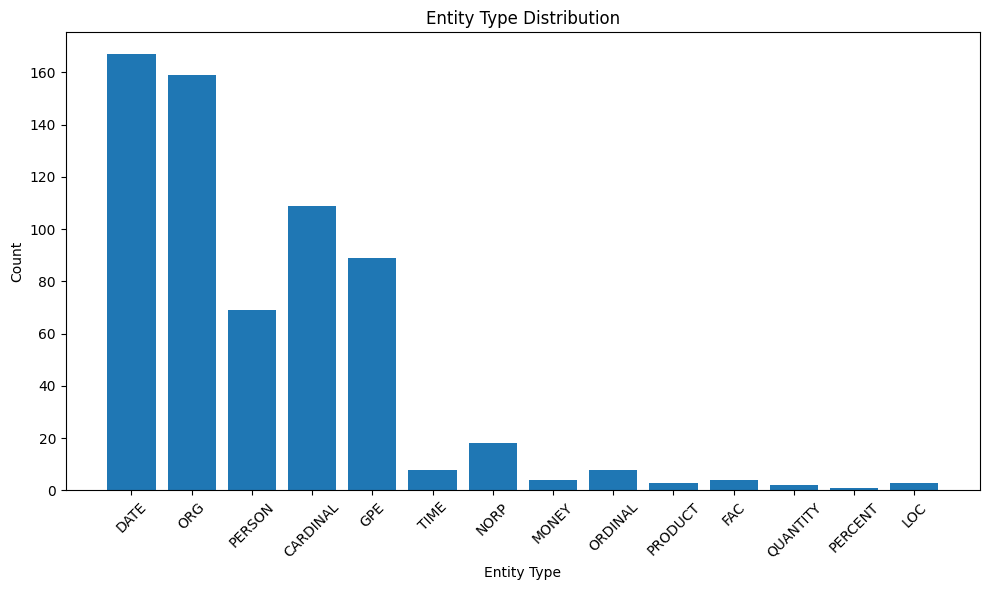

In [18]:
# For demonstration, let's simulate a CRF model comparison
print("Note: In a complete implementation, we would train a CRF model ")
print("on the CoNLL-2003 dataset and compare it with spaCy's model.")
print("For simplicity in this demonstration, we're only using spaCy's model.")

# Display entity distribution
entity_types = {}
for article_entities in all_entities:
    for entity, entity_type in article_entities:
        if entity_type not in entity_types:
            entity_types[entity_type] = 0
        entity_types[entity_type] += 1

# Plot entity type distribution
plt.figure(figsize=(10, 6))
plt.bar(entity_types.keys(), entity_types.values())
plt.title('Entity Type Distribution')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Relation Extraction

Now let's extract relations between the entities we identified.

In [25]:
# Initialize relation extractor
relation_extractor = SpacyRelationExtractor()

# Extract relations
all_relations = []
for i, text in enumerate(cleaned_texts):
    relations = relation_extractor.extract_relations(text)
    
    # Filter out self-relations
    filtered_relations = []
    for subject, predicate, obj in relations:
        # Skip if subject and object are the same entity
        if subject[0] != obj[0]:
            filtered_relations.append((subject, predicate, obj))
    
    all_relations.append(filtered_relations)
    
    print(f"\nRelations from article {i+1}: {article_titles[i]}")
    for subject, predicate, obj in filtered_relations:
        print(f"- {subject[0]} ({subject[1]}) --[{predicate}]--> {obj[0]} ({obj[1]})")

2025-03-07 21:17:35,898 - src.relation_extraction.extractor - INFO - Loaded spaCy model: en_core_web_sm



Relations from article 1: 
- Adriana Kugler (PERSON) --[say on]--> Friday (DATE)
- Adriana Kugler (PERSON) --[say_on]--> Friday (DATE)

Relations from article 2: 
- Nasdaq (ORG) --[confirm At]--> 255 pm (TIME)
- Richmond (GPE) --[related_to]--> Virginia (GPE)
- Thursday (DATE) --[related_to]--> Trump (PERSON)
- Nasdaq (ORG) --[confirm_At]--> 255 pm (TIME)

Relations from article 3: 
- Reuters - Morgan Stanley (ORG) --[lower on]--> Friday (DATE)
- Goldman Sachs (ORG) --[downgrade to]--> 17 (CARDINAL)
- Reuters - Morgan Stanley (ORG) --[lower_on]--> Friday (DATE)
- Goldman Sachs (ORG) --[downgrade_to]--> 17 (CARDINAL)
- Goldman Sachs (ORG) --[downgrade_from]--> 22 (CARDINAL)

Relations from article 4: 

Relations from article 5: 
- Donald Trump (PERSON) --[take on]--> January 20 (DATE)
- Justin Trudeau (PERSON) --[say on]--> Thursday (DATE)
- Donald Trump (PERSON) --[take_on]--> January 20 (DATE)

Relations from article 6: 
- Siri (PERSON) --[delay until]--> 2026 (DATE)
- Siri (PERSON) 

## 5. Knowledge Graph Construction

Now let's build a knowledge graph from the extracted entities and relations.

In [26]:
# Initialize knowledge graph builder
kg_builder = KnowledgeGraphBuilder(namespace="http://example.org/graphify/")

# Collect all entities and relations
all_kg_entities = set()
all_kg_relations = []

for entities in all_entities:
    for entity in entities:
        all_kg_entities.add(entity)

for relations in all_relations:
    all_kg_relations.extend(relations)

# Add to knowledge graph
kg_builder.add_entities_and_relations(list(all_kg_entities), all_kg_relations)

# Save knowledge graph to file
kg_file = "output/data/knowledge_graph.ttl"
kg_builder.save_to_file(kg_file, format="turtle")
print(f"\nKnowledge graph saved to {kg_file}")

# Display stats
print(f"\nKnowledge Graph Statistics:")
print(f"- Entities: {len(all_kg_entities)}")
print(f"- Relations: {len(all_kg_relations)}")
print(f"- Triples: {len(kg_builder.get_triples())}")

2025-03-07 21:17:44,438 - src.knowledge_graph.builder - INFO - Initialized knowledge graph with namespace: http://example.org/graphify/
2025-03-07 21:17:44,454 - src.knowledge_graph.builder - INFO - Added 396 entities and 32 relations
2025-03-07 21:17:44,486 - src.knowledge_graph.builder - INFO - Saved knowledge graph to output/data/knowledge_graph.ttl in turtle format



Knowledge graph saved to output/data/knowledge_graph.ttl

Knowledge Graph Statistics:
- Entities: 396
- Relations: 32
- Triples: 839


## 6. Visualization

Let's create visualizations of our knowledge graph.

2025-03-07 21:17:53,750 - src.knowledge_graph.builder - INFO - Saved plot to output/visualization/knowledge_graph_plot.png
2025-03-07 21:17:53,764 - src.knowledge_graph.builder - INFO - Saved visualization to output/visualization/knowledge_graph_interactive.html


Static plot saved to output/visualization/knowledge_graph_plot.png
Interactive visualization saved to output/visualization/knowledge_graph_interactive.html


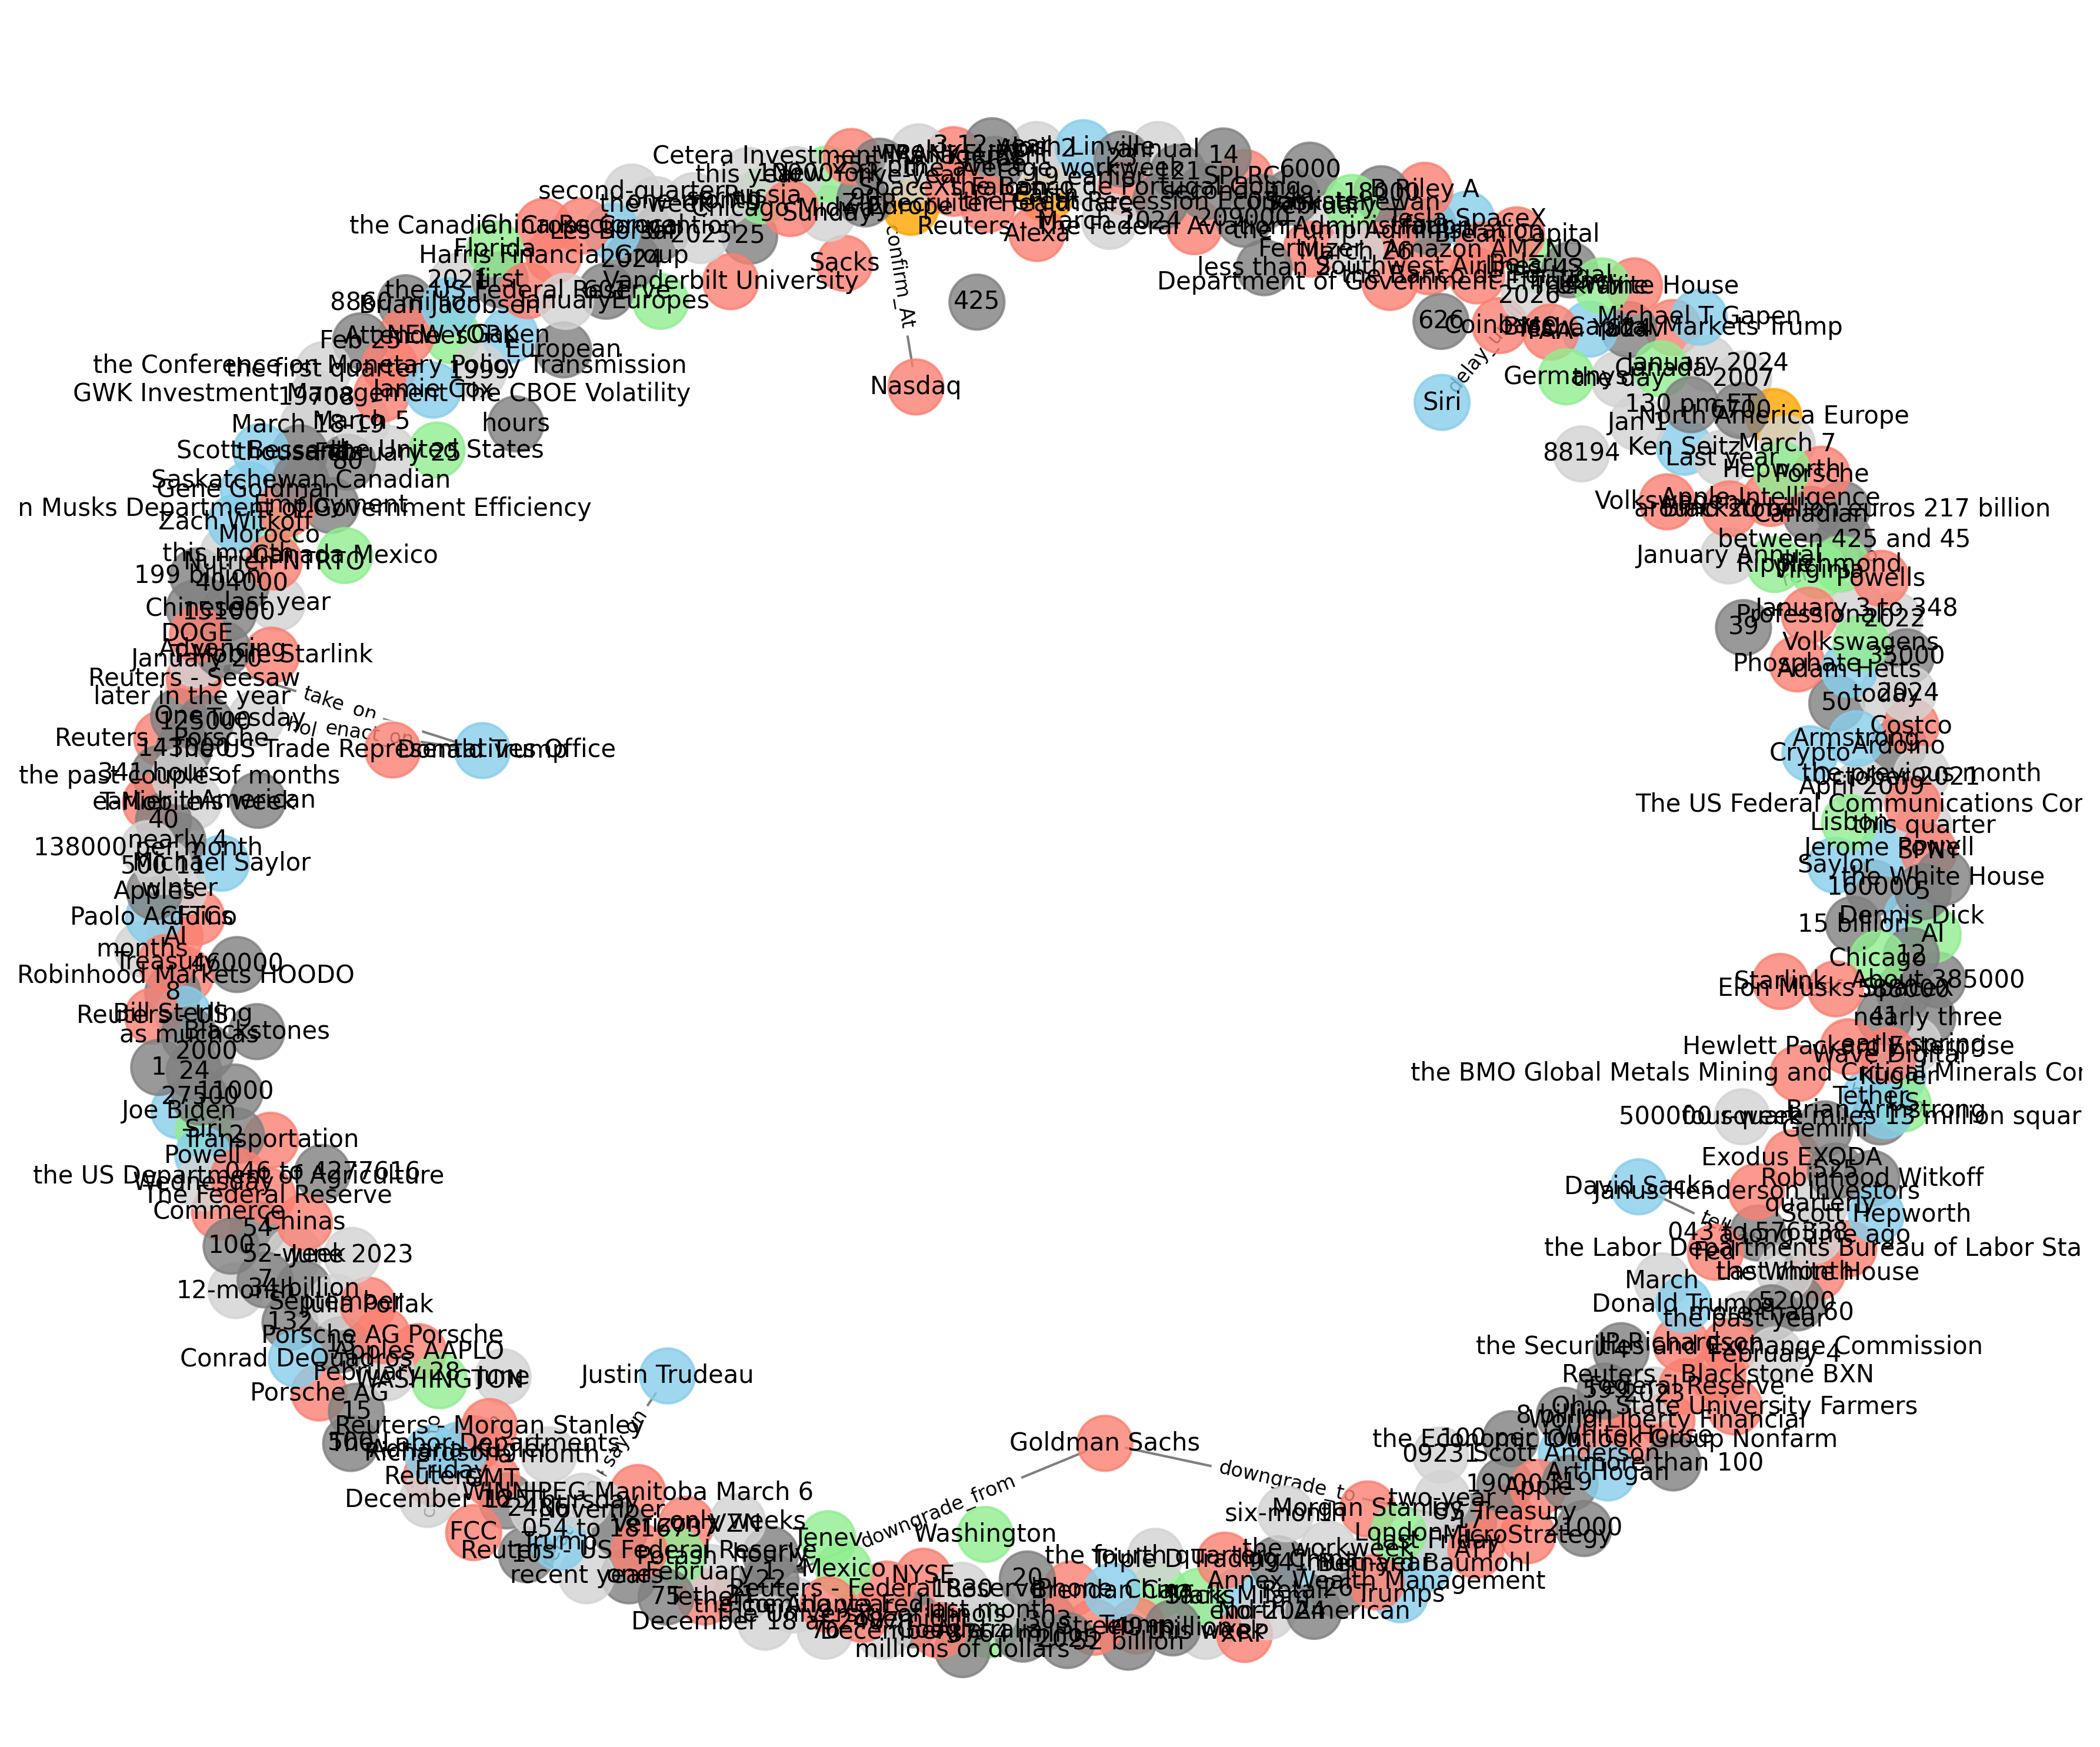

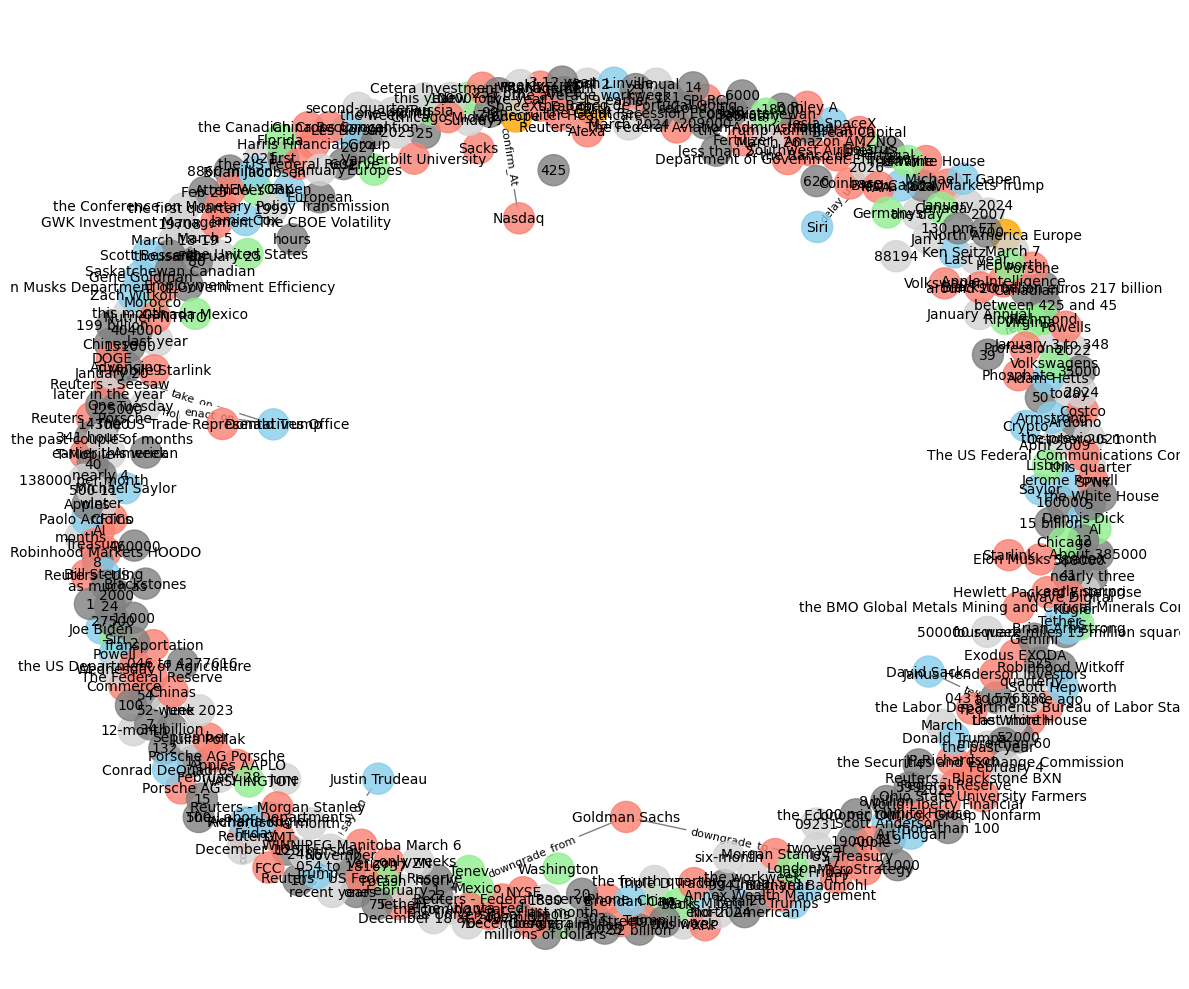

In [ ]:
# Create visualizations
# Before visualizing, filter out nodes without relations

# Get all entities that participate in relationships
connected_entities = set()
for relations in all_relations:
    for subject, predicate, obj in relations:
        connected_entities.add(subject[0])  # Add subject text
        connected_entities.add(obj[0])      # Add object text

# Filter the entities to only include those with relations
connected_kg_entities = [entity for entity in all_kg_entities if entity[0] in connected_entities]

# Now use the filtered entities for visualization
kg_builder = KnowledgeGraphBuilder(namespace="http://example.org/graphify/")
kg_builder.add_entities_and_relations(connected_kg_entities, all_kg_relations)

# Static plot
plot_file = "output/visualization/knowledge_graph_plot.png"
kg_builder.plot_graph(plot_file)
print(f"Static plot saved to {plot_file}")

# Interactive visualization
vis_file = "output/visualization/knowledge_graph_interactive.html"
kg_builder.visualize(vis_file)
print(f"Interactive visualization saved to {vis_file}")

# Display the static plot in the notebook
from IPython.display import Image
Image(filename=plot_file)

## 7. Querying the Knowledge Graph

Let's run some SPARQL queries on our knowledge graph.

In [22]:
# Example query 1: Find all organizations and their locations
query1 = """
PREFIX ns: <http://example.org/graphify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?org ?loc
WHERE {
    ?org_uri rdf:type ns:ORG .
    ?loc_uri rdf:type ns:GPE .
    ?org_uri ?pred ?loc_uri .
    ?org_uri <http://www.w3.org/2000/01/rdf-schema#label> ?org .
    ?loc_uri <http://www.w3.org/2000/01/rdf-schema#label> ?loc .
}
"""

results1 = kg_builder.query_sparql(query1)
print("Organizations and their locations:")
for row in results1:
    print(f"- {row[0]} is located in {row[1]}")

Organizations and their locations:


In [23]:
# Example query 2: Find all people and their organizations
query2 = """
PREFIX ns: <http://example.org/graphify/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?person ?org
WHERE {
    ?person_uri rdf:type ns:PERSON .
    ?org_uri rdf:type ns:ORG .
    ?pred_uri ?person_uri ?org_uri .
    ?person_uri <http://www.w3.org/2000/01/rdf-schema#label> ?person .
    ?org_uri <http://www.w3.org/2000/01/rdf-schema#label> ?org .
}
"""

results2 = kg_builder.query_sparql(query2)
print("People and their organizations:")
for row in results2:
    print(f"- {row[0]} is associated with {row[1]}")

People and their organizations:


## 8. Exporting Results for Further Analysis

Let's export the entities and relations to CSV files for further analysis.

In [24]:
# Export entities to CSV
entity_data = []
for entity_text, entity_type in all_kg_entities:
    entity_data.append({'entity': entity_text, 'type': entity_type})

entity_df = pd.DataFrame(entity_data)
entity_csv = "output/data/entities.csv"
entity_df.to_csv(entity_csv, index=False)
print(f"Entities exported to {entity_csv}")

# Export relations to CSV
relation_data = []
for subject, predicate, obj in all_kg_relations:
    relation_data.append({
        'subject': subject[0],
        'subject_type': subject[1],
        'predicate': predicate,
        'object': obj[0],
        'object_type': obj[1]
    })

relation_df = pd.DataFrame(relation_data)
relation_csv = "output/data/relations.csv"
relation_df.to_csv(relation_csv, index=False)
print(f"Relations exported to {relation_csv}")

Entities exported to output/data/entities.csv
Relations exported to output/data/relations.csv


## 9. Conclusion

In this notebook, we've demonstrated the complete pipeline for building a knowledge graph from raw text data:

1. We collected articles using a web scraper
2. We preprocessed and cleaned the text
3. We extracted named entities using spaCy
4. We extracted relations between entities
5. We built a knowledge graph from the entities and relations
6. We visualized and queried the knowledge graph

This pipeline can be extended by:
- Training a CRF model for NER and comparing it with spaCy's performance
- Implementing more sophisticated relation extraction methods
- Adding more data sources
- Expanding the knowledge graph with additional entity types and relations
- Developing applications that use the knowledge graph for search, recommendation, or other tasks